In [1]:
import os
import sys
import inspect
# Insert modules directory, TODO create setup.py file
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
reports_dir = os.path.dirname(currentdir)
project_home_dir = os.path.dirname(reports_dir)
sys.path.insert(0, f"{project_home_dir}/qcnn")

In [2]:
import numpy as np
import pandas as pd
from pprint import pprint
from reporting_functions import get_file_content, get_result_table
from joblib import dump, load
from collections import namedtuple

In [3]:
experiments_path = f"{project_home_dir}/experiments"
experiment_filename = "experiment.json"
target_levels = ["classical", "country", "rock", "pop", "hiphop", "jazz", "blues", "disco", "metal", "reggae"]

In [12]:
experiment_id = 117
experiment_config = get_file_content(
    f"{experiments_path}/{experiment_id}/{experiment_filename}"
)

In [18]:
pprint(experiment_config)

{'ID': 117,
 'data': {'path': '/home/matt/dev/projects/quantum-cnn/data/archive/Data/features_30_sec.csv',
          'sampling': {'random_state': 42, 'test_size': 0.3},
          'target_column': 'label',
          'target_pairs': [],
          'type': '2d'},
 'extra_info': 'main',
 'model': {'classical': {'cnn': {'ignore': True, 'param_grid': {}},
                         'logistic_regression': {'ignore': False,
                                                 'param_grid': {'C': [0.001,
                                                                      0.01,
                                                                      0.1,
                                                                      1.0,
                                                                      10.0,
                                                                      100.0,
                                                                      1000.0],
                                                

In [19]:
path = f"{experiment_config.get('path')}/{experiment_config.get('ID')}"

In [20]:
y_test = pd.read_csv(f"{path}/y_test.csv", index_col=0)

In [21]:
model_names = [
    filename.split("-model_configuration.joblib")[0]
    for filename in os.listdir(path)
    if "-model_configuration.joblib" in filename
]
# Gather results
Results = namedtuple(
    "Results", ["model_name", "y_test_hat", "clf", "model_configuration", "samples_tfd"]
)
result_list = []
for model_name in model_names:
    y_test_hat = pd.read_csv(f"{path}/{model_name}-yhat.csv", index_col=0)
    clf = load(f"{path}/{model_name}-clf_results.joblib")
    model_configuration = load(f"{path}/{model_name}-model_configuration.joblib")
    samples_tfd = load(f"{path}/{model_name}-samples_tfd.joblib")
    result_list = result_list + [
        Results(
            model_name,
            y_test_hat=y_test_hat,
            clf=clf,
            model_configuration=model_configuration,
            samples_tfd=samples_tfd,
        )
    ]
print(len(result_list))

16


In [22]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

result_data = pd.DataFrame(
    {
        "model_name": [],
        "model_type": [],
        "algorithm": [],
        "classification_type": [],
        "embedding_type": [],
        "scaler_method": [],
        "scaler_param_str": [],
        "selection_method": [],
        "selection_param_str": [],
        "target_pair": [],
        "additional_structure": [],
        "target_pair_str":[],
        "mean_test_score":[],
        "std_test_score":[],
        "params":[],
        "accuracy": [],
        "precision": [],
        "recall": [],
        "f1": [],
        "loss_train_history": [],
    }
)
for result in result_list:
    y_test_hat = result.y_test_hat
    clf = result.clf
    model_configuration = result.model_configuration
    samples_tfd = result.samples_tfd
    model_name = result.model_name

    precision, recall, fscore, support = precision_recall_fscore_support(
        samples_tfd.y_test, y_test_hat
    )
    accuracy = accuracy_score(samples_tfd.y_test, y_test_hat)
    tmp_result = model_configuration._asdict()
    tmp_result["model_name"] = model_name
    
    tmp_result["target_pair_str"] = None
    tmp_result["mean_test_score"] = clf.cv_results_["mean_test_score"][clf.best_index_]
    tmp_result["std_test_score"] = clf.cv_results_["std_test_score"][clf.best_index_]
    tmp_result["params"] = clf.cv_results_["params"][clf.best_index_]
    
    tmp_result["accuracy"] = accuracy
    tmp_result["precision"] = precision
    tmp_result["recall"] = recall
    tmp_result["f1"] = fscore
    tmp_result["loss_train_history"] = None  # set for quantum
    result_data = result_data.append(tmp_result, ignore_index=True)

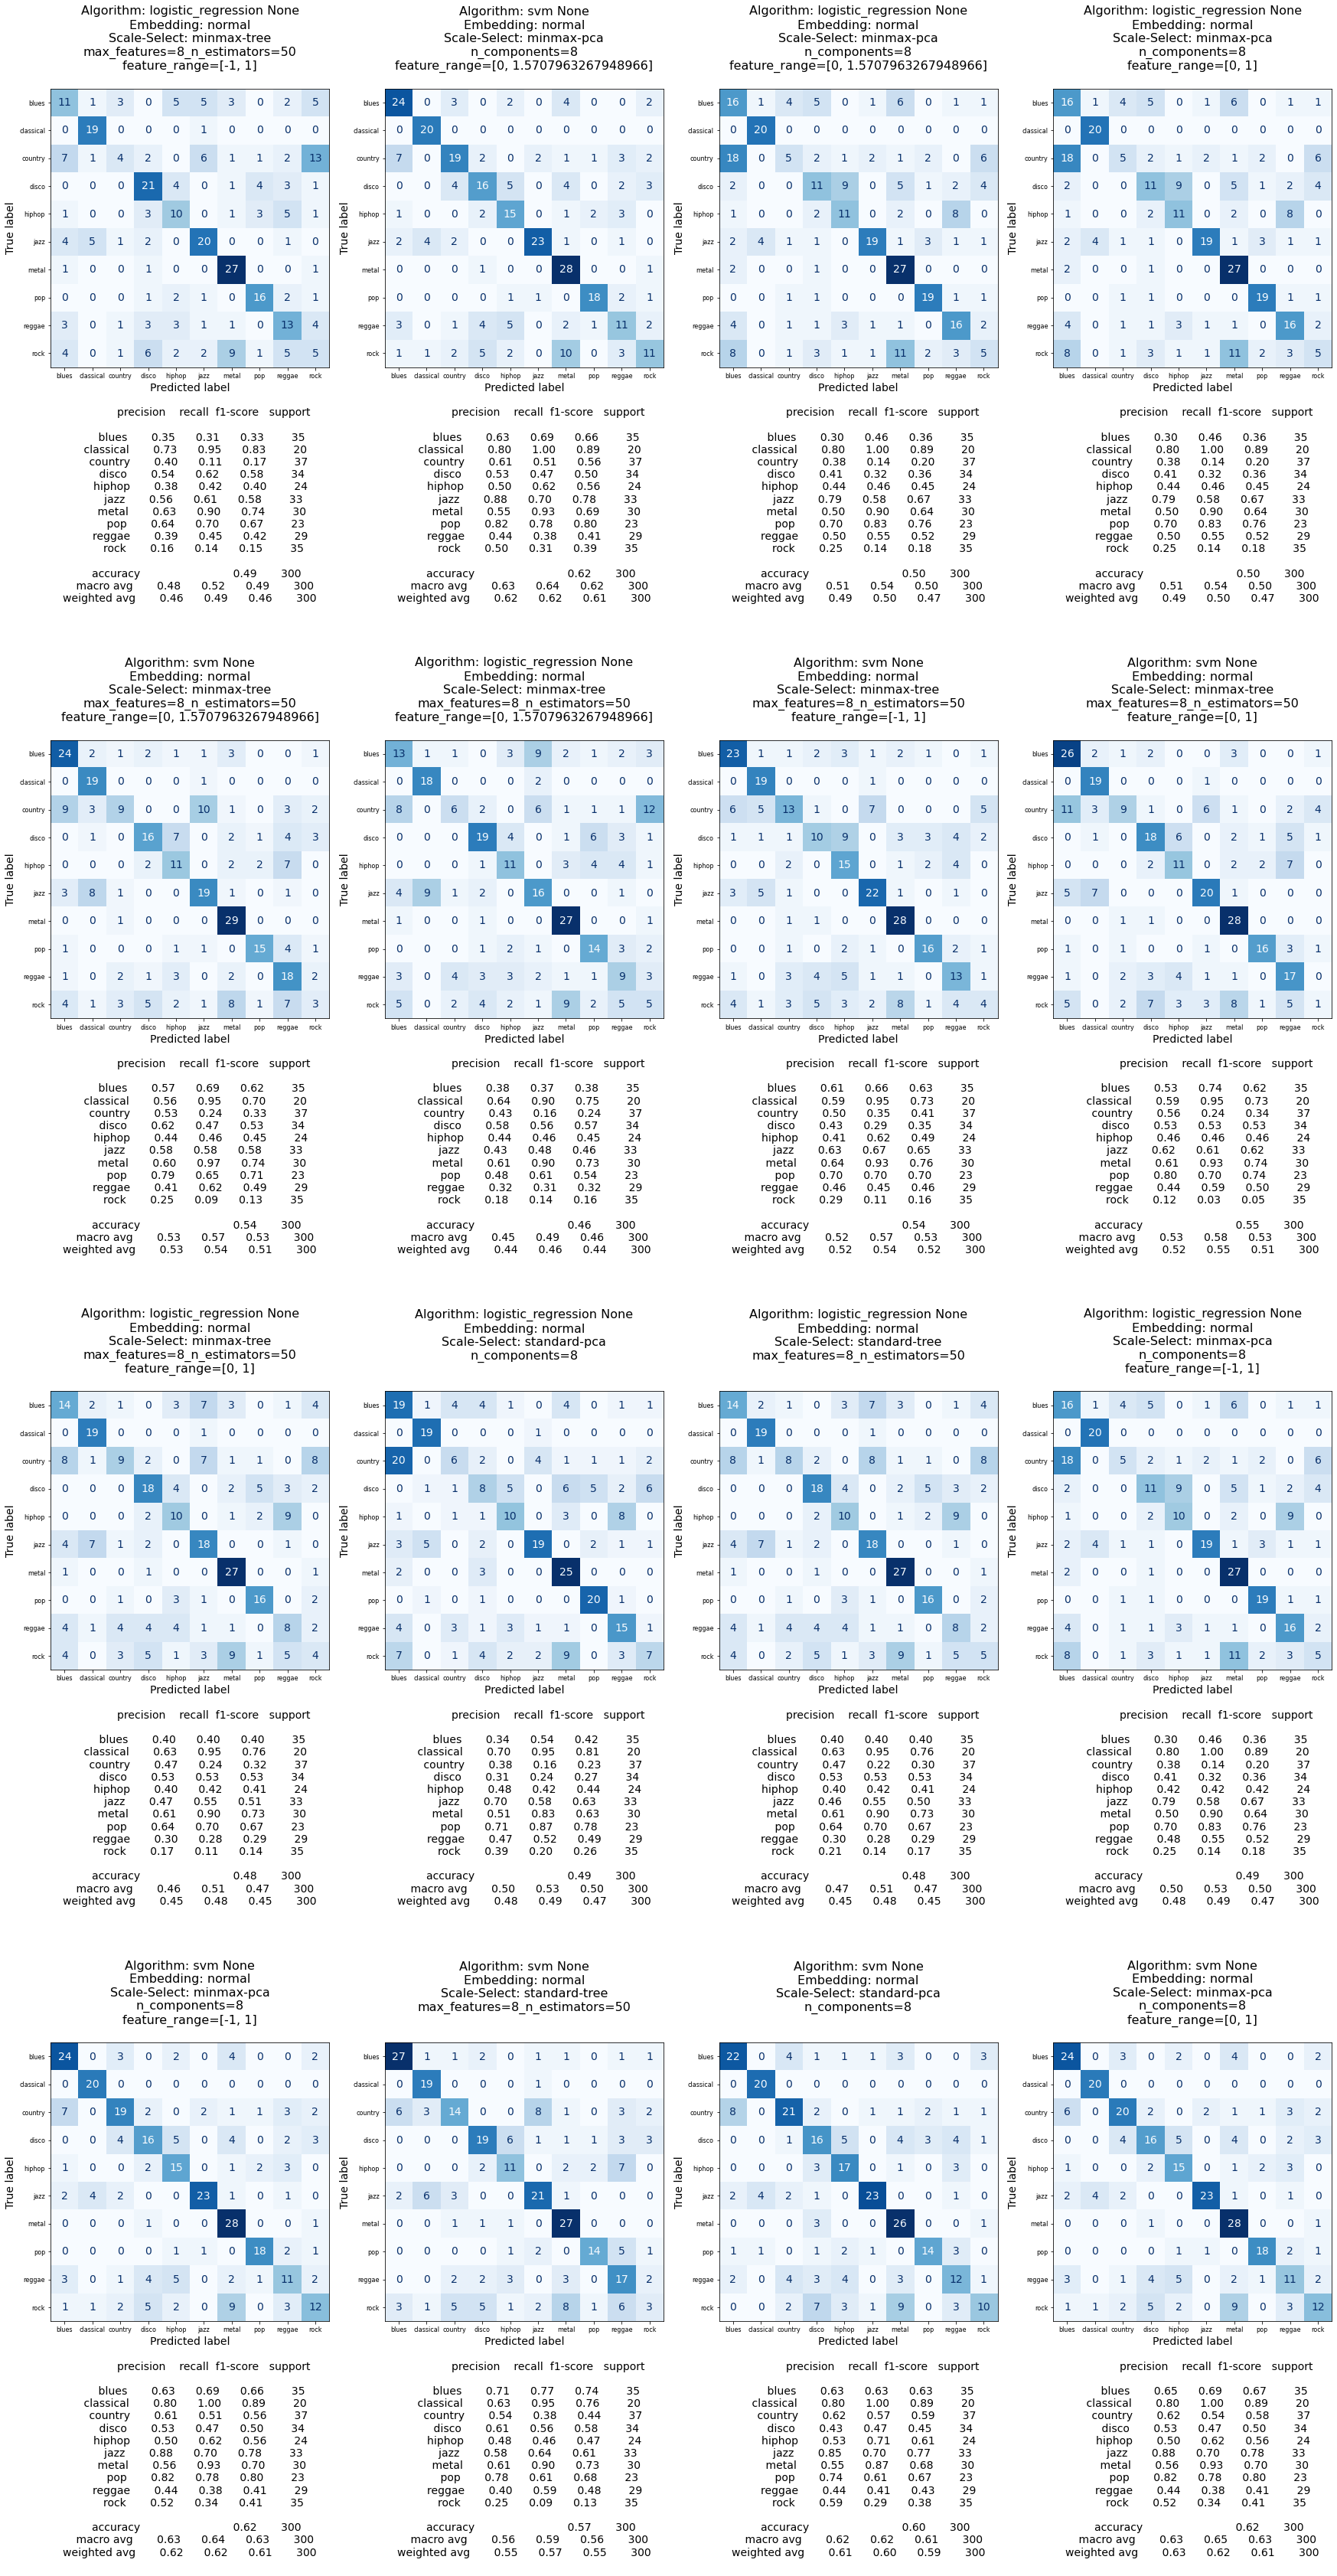

In [23]:
%matplotlib inline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

import matplotlib.pyplot as plt

# Customize matplotlib
SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc("font", size=MEDIUM_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

row_width = 30
row_height = 15
columns_in_row = 4
n_plots = len(result_list)
n_rows = int(np.ceil(n_plots / columns_in_row))
fig, axes = plt.subplots(n_rows, columns_in_row, figsize=(row_width, n_rows * row_height))
for result, i in zip(result_list, range(n_plots)):
    col = i % columns_in_row
    row = int(np.floor(i / columns_in_row))
    y_test_hat = result.y_test_hat
    clf = result.clf
    model_configuration = result.model_configuration
    samples_tfd = result.samples_tfd
    model_name = result.model_name

    display_report = classification_report(samples_tfd.y_test, y_test_hat)
    title_text = (
        f"Algorithm: {model_configuration.algorithm} {model_configuration.target_pair}\n"
        f"Embedding: {model_configuration.embedding_type}\n"
        f"Scale-Select: {model_configuration.scaler_method}-{model_configuration.selection_method}\n"
        f"{model_configuration.scaler_param_str}\n{model_configuration.selection_param_str}\n"
    )
    axes[row, col].grid(False)
    ConfusionMatrixDisplay.from_predictions(
        samples_tfd.y_test, y_test_hat, ax=axes[row, col], cmap=plt.cm.Blues
    )

    axes[row, col].set_title(title_text)
    axes[row, col].set_xlabel(f"Predicted label\n\n{display_report}")
    im = axes[row, col].images
    cb = im[-1].colorbar
    cb.remove()


plt.close()
#plt.tight_layout()
fig

In [24]:
get_result_table(result_data, ["selection_method", "scaler_method", "selection_param_str", "scaler_param_str", "algorithm"], "accuracy")

algorithm,logistic_regression,svm,selection_method Average
"(pca, minmax, feature_range=[-1, 1], n_components=8)",0.493333,0.620000,0.556667
"(pca, minmax, feature_range=[0, 1.5707963267948966], n_components=8)",0.496667,0.616667,0.556667
"(pca, minmax, feature_range=[0, 1], n_components=8)",0.496667,0.623333,0.560000
"(pca, standard, , n_components=8)",0.493333,0.603333,0.548333
"(tree, minmax, feature_range=[-1, 1], max_features=8_n_estimators=50)",0.486667,0.543333,0.515000
"(tree, minmax, feature_range=[0, 1.5707963267948966], max_features=8_n_estimators=50)",0.460000,0.543333,0.501667
"(tree, minmax, feature_range=[0, 1], max_features=8_n_estimators=50)",0.476667,0.550000,0.513333
"(tree, standard, , max_features=8_n_estimators=50)",0.476667,0.573333,0.525000
scaler_method Average,0.485000,0.584167,0.534583


In [25]:
get_result_table(result_data, ["selection_method", "scaler_method", "selection_param_str", "scaler_param_str", "algorithm"], "mean_test_score")

algorithm,logistic_regression,svm,selection_method Average
"(pca, minmax, feature_range=[-1, 1], n_components=8)",0.548571,0.618571,0.583571
"(pca, minmax, feature_range=[0, 1.5707963267948966], n_components=8)",0.548571,0.618571,0.583571
"(pca, minmax, feature_range=[0, 1], n_components=8)",0.547143,0.617143,0.582143
"(pca, standard, , n_components=8)",0.548571,0.628571,0.588571
"(tree, minmax, feature_range=[-1, 1], max_features=8_n_estimators=50)",0.552857,0.590000,0.571429
"(tree, minmax, feature_range=[0, 1.5707963267948966], max_features=8_n_estimators=50)",0.552857,0.577143,0.565000
"(tree, minmax, feature_range=[0, 1], max_features=8_n_estimators=50)",0.525714,0.570000,0.547857
"(tree, standard, , max_features=8_n_estimators=50)",0.527143,0.611429,0.569286
scaler_method Average,0.543929,0.603929,0.573929


In [26]:
get_result_table(result_data, ["selection_method", "scaler_method", "selection_param_str", "scaler_param_str", "algorithm"], "std_test_score")

algorithm,logistic_regression,svm,selection_method Average
"(pca, minmax, feature_range=[-1, 1], n_components=8)",0.024495,0.018406,0.021450
"(pca, minmax, feature_range=[0, 1.5707963267948966], n_components=8)",0.024908,0.018406,0.021657
"(pca, minmax, feature_range=[0, 1], n_components=8)",0.027701,0.016036,0.021868
"(pca, standard, , n_components=8)",0.034523,0.046511,0.040517
"(tree, minmax, feature_range=[-1, 1], max_features=8_n_estimators=50)",0.042523,0.025794,0.034158
"(tree, minmax, feature_range=[0, 1.5707963267948966], max_features=8_n_estimators=50)",0.031493,0.018295,0.024894
"(tree, minmax, feature_range=[0, 1], max_features=8_n_estimators=50)",0.027701,0.016537,0.022119
"(tree, standard, , max_features=8_n_estimators=50)",0.028356,0.025794,0.027075
scaler_method Average,0.030213,0.023222,0.026717
